In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from fig_style import *

import sys
sys.path.insert(0,'../')
from disk_model import DiskFitting, DiskImage

import astropy.constants as const
au = const.au.cgs.value
G = const.G.cgs.value
kB = const.k_B.cgs.value
yr = 365*24*3600
mp = const.m_p.cgs.value

In [2]:
def plot_one_line(R, y, w, end_color='tab:blue', **kwargs):
    p,=plt.plot(R, y, 'k', alpha=0.1*w, **kwargs)
    plt.plot(R[-1:], y[-1:], color=end_color, alpha=0.5*w, marker='o', mec='None', zorder=100)
from get_chi_sq import get_mean_chisq
def plot_many_line(Ds, ys, end_color='tab:blue', **kwargs):
    for i in range(len(Ds)):
        R = Ds[i].disk_model.R[1:]/au
        y = ys[i]
        chisq = get_mean_chisq(Ds[i])
        w = 0
        if chisq<=2:
            w = min(2-chisq, 1)
        plot_one_line(R, y, w, end_color=end_color, **kwargs)
def set_axis():
    plt.xscale('log'); plt.xlim(3,500); plt.yscale('log'); set_ticks()

In [3]:
with open("../data/fitted_systems/fit_1mm_Q1d5_age1e5.pkl","rb") as f:
    Ds = pickle.load(f)

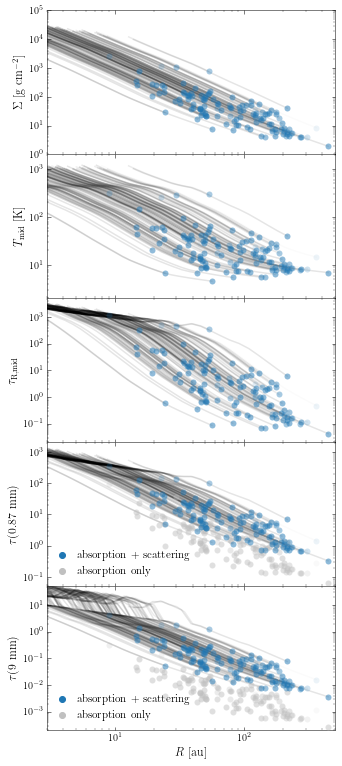

In [22]:
N = 5
fig = plt.figure(figsize=(4, 2*N))
i = 0

ax = fig.add_axes([0, 1-(i+1)/N, 1, 1/N]); i += 1
Sigmas = [D.disk_model.Sigma for D in Ds]
Sigmas = np.array(Sigmas)
truncated = Sigmas==0
Sigmas[truncated] = np.nan
plot_many_line(Ds, Sigmas)
set_axis()
plt.gca().set_xticklabels([])
plt.ylabel(r'$\Sigma$ [g cm$^{-2}$]'); plt.ylim(1, 1e5)

ax = fig.add_axes([0, 1-(i+1)/N, 1, 1/N]); i += 1
Ts = [D.disk_model.T_mid for D in Ds]
Ts = np.array(Ts)
Ts[truncated] = np.nan
plot_many_line(Ds, Ts)
set_axis()
plt.gca().set_xticklabels([])
plt.ylabel(r'$T_{\rm mid}$ [K]'); plt.ylim(2, 2000)

ax = fig.add_axes([0, 1-(i+1)/N, 1, 1/N]); i += 1
tauRs = [D.disk_model.tau_r_mid for D in Ds]
tauRs = np.array(tauRs)
tauRs[truncated] = np.nan
plot_many_line(Ds, tauRs)
set_axis()
plt.gca().set_xticklabels([])
plt.ylabel(r'$\tau_{\rm R, mid}$'); plt.ylim(0.02, 5e3)

ax = fig.add_axes([0, 1-(i+1)/N, 1, 1/N]); i += 1

tauAs = [D.disk_model.tau_a_obs[0] for D in Ds]
tauAs = np.array(tauAs)
tauAs[truncated] = np.nan
plot_many_line(Ds, tauAs, ls='None', end_color='silver')

tauAs = [D.disk_model.tau_obs[0] for D in Ds]
tauAs = np.array(tauAs)
tauAs[truncated] = np.nan
plot_many_line(Ds, tauAs)

p1,=plt.plot([],[],ls='None',marker='o',color='tab:blue',label=r'absorption + scattering')
p2,=plt.plot([],[],ls='None',marker='o',color='silver',label=r'absorption only')
plt.legend(handles=[p1,p2],loc=3,frameon=False, handlelength=1.0)

set_axis()
plt.gca().set_xticklabels([])
plt.ylabel(r'$\tau({\rm 0.87~mm})$'); plt.ylim(5e-2, 2e3)

ax = fig.add_axes([0, 1-(i+1)/N, 1, 1/N]); i += 1

tauVs = [D.disk_model.tau_a_obs[1] for D in Ds]
tauVs = np.array(tauVs)
tauVs[truncated] = np.nan
plot_many_line(Ds, tauVs, ls='None', end_color='silver')

tauVs = [D.disk_model.tau_obs[1] for D in Ds]
tauVs = np.array(tauVs)
tauVs[truncated] = np.nan
plot_many_line(Ds, tauVs)

p1,=plt.plot([],[],ls='None',marker='o',color='tab:blue',label=r'absorption + scattering')
p2,=plt.plot([],[],ls='None',marker='o',color='silver',label=r'absorption only')
plt.legend(handles=[p1,p2],loc=3,frameon=False, handlelength=1.0)

set_axis()
#plt.gca().set_xticklabels([])
plt.ylabel(r'$\tau({\rm 9~mm})$'); plt.ylim(2e-4, 5e1)
plt.xlabel(r'$R$ [au]')

plt.savefig('../figures/radial_profile.pdf',bbox_inches='tight')

In [7]:
from disk_model import get_u
def get_Omega_tau_cool(D):
    tau_min, N_tau = 0.01, 100
    tau_max = D.disk_model.tau_r_mid*2
    tau_min = np.minimum(tau_max/N_tau,tau_min)
    tau_grid = np.logspace(np.log10(tau_min), np.log10(tau_max/2), N_tau) # first dimension: tau, second dimension: r
    tau_grid = np.concatenate((tau_grid, tau_max - tau_grid[-2::-1], [tau_max]), axis=0)
    dtau_grid = tau_grid*1
    dtau_grid[1:] = dtau_grid[1:]-dtau_grid[:-1]
    tau_p = D.disk_model.tau_p_mid*2
    tau_r = D.disk_model.tau_r_mid*2
    # get temperature profile
    T_4_over_T_mid_4 = (tau_grid*(1-tau_grid/tau_r) + 1/np.sqrt(3) + 1/(1.5*tau_p))/\
                       (0.25*tau_r + 1/np.sqrt(3) + 1/(1.5*tau_p))
    T_grid = T_4_over_T_mid_4**(1/4) * D.disk_model.T_mid
    # column density profile
    dSigma = dtau_grid/D.disk_model.get_kappa_r(T_grid)
    # extra mass at midplane
    Sigma_extra = D.disk_model.Sigma-np.sum(dSigma, axis=0)
    # internal energy
    U = np.sum(dSigma*get_u(T_grid), axis=0) + Sigma_extra*get_u(D.disk_model.T_mid)
    # accretion heating rate
    Omega_sq = G*D.disk_model.MR/D.disk_model.R[1:]**3
    heat_per_area = Omega_sq*D.disk_model.Mdot
    tau_cool = U/heat_per_area
    return np.sqrt(Omega_sq)*tau_cool

0.8466257668711656
0.9447852760736196


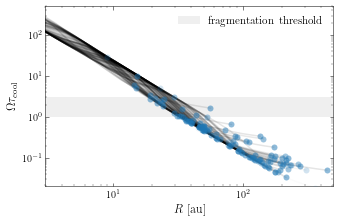

In [16]:
N = 1
fig = plt.figure(figsize=(4, 2.5*N))
i = 0

ax = fig.add_axes([0, 1-(i+1)/N, 1, 1/N]); i += 1
Omega_tau_cool = [get_Omega_tau_cool(D) for D in Ds]
Omega_tau_cool = np.array(Omega_tau_cool)
Sigmas = [D.disk_model.Sigma for D in Ds]
Sigmas = np.array(Sigmas)
Omega_tau_cool[Sigmas==0] = np.nan
plot_many_line(Ds, Omega_tau_cool)

print(sum(Omega_tau_cool[:,-1]<1)/sum(Omega_tau_cool[:,-1]>0))
print(sum(Omega_tau_cool[:,-1]<3)/sum(Omega_tau_cool[:,-1]>0))

set_axis()
plt.ylabel(r'$\Omega\tau_{\rm cool}$'); plt.ylim(2e-2, 5e2)
plt.xlabel(r'$R$ [au]')

p = plt.fill_between(plt.xlim(), [1,1], [3,3], color='silver', lw=0, alpha=.25)
plt.legend([p],['fragmentation threshold'], frameon=False)

plt.savefig('../figures/Omega_tau_cool.pdf',bbox_inches='tight')

In [9]:
from disk_model import get_cs
mu = 2.33 # mean molecular weight
def get_stopping_time_per_orbit(DF, a=1, mode=0):
    D = DF.disk_model
    Omega = np.sqrt(G*D.MR/D.R[1:]**3)
    cs_mid = get_cs(D.T_mid)
    H = cs_mid/Omega
    rho = D.Sigma/(2*H)
    n = rho/(mu*mp)
    # mode 0: check if it's epstein
    sigma_H2 = 2e-15
    lam_mfp = 1/(n*sigma_H2)
    if mode==0:
        return lam_mfp/a
    # mode 1: compute stopping time
    tau_s = np.zeros(n.shape)
    u_thermal = np.sqrt(kB*D.T_mid/(mu*mp))
    rhos = 1.675
    tau_s_epstein = rhos*a/(rho*u_thermal)
    tau_s = tau_s_epstein # assume epstein
    if mode==1:
        return tau_s
    # mode 2: stokes number
    tau_ed = 1/Omega # eddy turnover ~ sound crossing time at H
    St = tau_s/tau_ed
    if mode==2:
        return St
    # mode 3: radial drift timescale
    u_n = 1 * get_cs(D.T_mid)**2/D.R[1:] / (2*Omega)# eq. 20, assuming efficiency Ed=1 and dP/dr = P/r
    u_r = 2*u_n/(St+1/St)
    radial_drift_timescale_yr = D.R[1:]/u_r/yr
    if mode==3:
        return radial_drift_timescale_yr

/tmp/ipykernel_2230886/811166270.py:12: RuntimeWarning: divide by zero encountered in true_divide
  lam_mfp = 1/(n*sigma_H2)
/tmp/ipykernel_2230886/811166270.py:19: RuntimeWarning: divide by zero encountered in true_divide
  tau_s_epstein = rhos*a/(rho*u_thermal)
/tmp/ipykernel_2230886/811166270.py:31: RuntimeWarning: divide by zero encountered in true_divide
  radial_drift_timescale_yr = D.R[1:]/u_r/yr
/tmp/ipykernel_2230886/811166270.py:12: RuntimeWarning: divide by zero encountered in true_divide
  lam_mfp = 1/(n*sigma_H2)
/tmp/ipykernel_2230886/811166270.py:19: RuntimeWarning: divide by zero encountered in true_divide
  tau_s_epstein = rhos*a/(rho*u_thermal)
/tmp/ipykernel_2230886/811166270.py:31: RuntimeWarning: divide by zero encountered in true_divide
  radial_drift_timescale_yr = D.R[1:]/u_r/yr


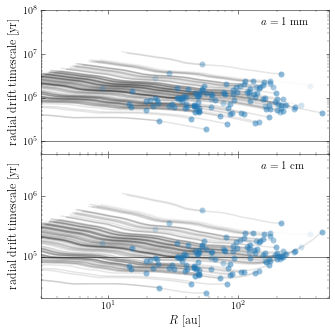

In [10]:
N = 2
fig = plt.figure(figsize=(4, 2*N))
i = 0

ax = fig.add_axes([0, 1-(i+1)/N, 1, 1/N]); i += 1
y = [get_stopping_time_per_orbit(D, a=0.1, mode=3) for D in Ds]
y = np.array(y)
Sigmas = [D.disk_model.Sigma for D in Ds]
Sigmas = np.array(Sigmas)
y[Sigmas==0] = np.nan
plot_many_line(Ds, y)

plt.plot(plt.xlim(),[1e5,1e5],'-',color='k', lw=.5, zorder=-1)
plt.ylim(5e4, 1e8)
yl, yh = plt.ylim()
plt.text(150, yh**0.9*yl**0.1, r'$a = 1$ mm', fontsize=11)

set_axis()
plt.gca().set_xticklabels([])
plt.ylabel(r'radial drift timescale [yr]')

ax = fig.add_axes([0, 1-(i+1)/N, 1, 1/N]); i += 1
y = [get_stopping_time_per_orbit(D, a=1, mode=3) for D in Ds]
y = np.array(y)
Sigmas = [D.disk_model.Sigma for D in Ds]
Sigmas = np.array(Sigmas)
y[Sigmas==0] = np.nan
plot_many_line(Ds, y)

plt.plot(plt.xlim(),[1e5,1e5],'-',color='k', lw=.5, zorder=-1)
plt.ylim(2e4, 5e6)
yl, yh = plt.ylim()
plt.text(150, yh**0.9*yl**0.1, r'$a = 1$ cm', fontsize=11)

set_axis()
plt.ylabel(r'radial drift timescale [yr]')
plt.xlabel(r'$R$ [au]')
plt.savefig('../figures/dust_drift_timescale.pdf',bbox_inches='tight')

/tmp/ipykernel_2230886/811166270.py:12: RuntimeWarning: divide by zero encountered in true_divide
  lam_mfp = 1/(n*sigma_H2)
/tmp/ipykernel_2230886/811166270.py:19: RuntimeWarning: divide by zero encountered in true_divide
  tau_s_epstein = rhos*a/(rho*u_thermal)
/tmp/ipykernel_2230886/811166270.py:12: RuntimeWarning: divide by zero encountered in true_divide
  lam_mfp = 1/(n*sigma_H2)
/tmp/ipykernel_2230886/811166270.py:19: RuntimeWarning: divide by zero encountered in true_divide
  tau_s_epstein = rhos*a/(rho*u_thermal)


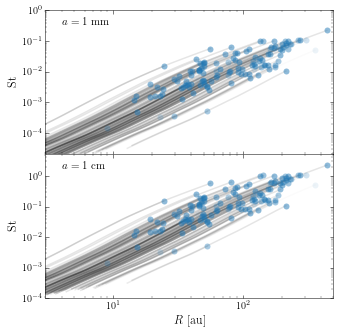

In [15]:
N = 2
fig = plt.figure(figsize=(4, 2*N))
i = 0

ax = fig.add_axes([0, 1-(i+1)/N, 1, 1/N]); i += 1
y = [get_stopping_time_per_orbit(D, a=0.1, mode=2) for D in Ds]
y = np.array(y)
Sigmas = [D.disk_model.Sigma for D in Ds]
Sigmas = np.array(Sigmas)
y[Sigmas==0] = np.nan
plot_many_line(Ds, y)

plt.ylim(2e-5, 1)
yl, yh = plt.ylim()
plt.text(4, yh**0.9*yl**0.1, r'$a = 1$ mm', fontsize=11)

set_axis()
plt.gca().set_xticklabels([])
plt.ylabel(r'St')

ax = fig.add_axes([0, 1-(i+1)/N, 1, 1/N]); i += 1
y = [get_stopping_time_per_orbit(D, a=1, mode=2) for D in Ds]
y = np.array(y)
Sigmas = [D.disk_model.Sigma for D in Ds]
Sigmas = np.array(Sigmas)
y[Sigmas==0] = np.nan
plot_many_line(Ds, y)

plt.ylim(1e-4, 5)
yl, yh = plt.ylim()
plt.text(4, yh**0.9*yl**0.1, r'$a = 1$ cm', fontsize=11)

set_axis()
plt.ylabel(r'St')
plt.xlabel(r'$R$ [au]')
plt.savefig('../figures/dust_drift_St.pdf',bbox_inches='tight')